# The Image Captioning Using CNN-RNN

In this project, the first step is to make a CNN-RNN network to do image captioning.

First, import some important libraries

In [1]:
# import lib
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path

## 1. Import dataset flicker 8k and explore the dataset

The flicker 8k is used in this project, because this is small. Each sentence have five captions. 

In [83]:
import pandas as pd
# caption_file = './flickr8k/captions.txt'
caption_file = './caption_val.txt'
dataset = pd.read_csv(caption_file)

Now, exploring the data structure of flicker 8k

In [84]:
dataset.head(10)

,image,caption
0,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
1,1003163366_44323f5815.jpg,A man lays on the bench to which a white dog i...
2,1003163366_44323f5815.jpg,a man sleeping on a bench outside with a white...
3,1003163366_44323f5815.jpg,A shirtless man lies on a park bench with his ...
4,1003163366_44323f5815.jpg,man laying on bench holding leash of dog sitti...
5,1007129816_e794419615.jpg,A man in an orange hat starring at something .
6,1007129816_e794419615.jpg,A man wears an orange hat and glasses .
7,1007129816_e794419615.jpg,A man with gauges and glasses is wearing a Bli...
8,1007129816_e794419615.jpg,A man with glasses is wearing a beer can croch...
9,1007129816_e794419615.jpg,The man with pierced ears is wearing glasses a...


There are 40455 captions and images, 6472 in train and 1619 in val.

In [85]:
image_names = dataset['image'].unique()
image_captions = dataset['caption']
print("There are {} images".format(len(image_names)))
print("There are {} captions".format(len(image_captions)))
print(image_names[0])

There are 1619 images
There are 8095 captions
1003163366_44323f5815.jpg


The image and corresponding captions are as follow:

./image_train/1007320043_627395c3d8.jpg


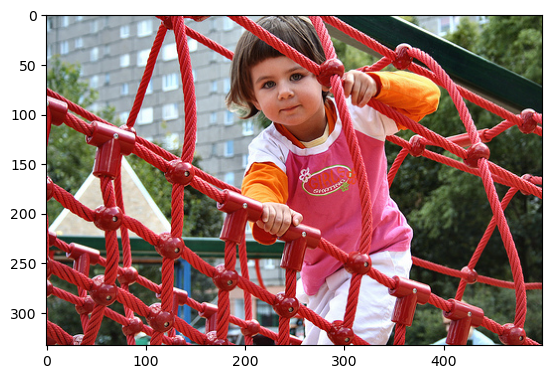

A child playing on a rope net .
A little girl climbing on red roping .
A little girl in pink climbs a rope bridge at the park .
A small child grips onto the red ropes at the playground .
The small child climbs on a red ropes on a playground .


In [63]:
image_idx = 3

# get the path of image
# image_path = "./flickr8k/Images/"+image_names[image_idx]
image_path = "./image_train/"+image_names[image_idx]
print(image_path)
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
for i in range(image_idx*5,image_idx*5+5):
    print(image_captions[i])

Another task is using the image name to find the corresponding captions:

./flickr8k/Images/1001773457_577c3a7d70.jpg


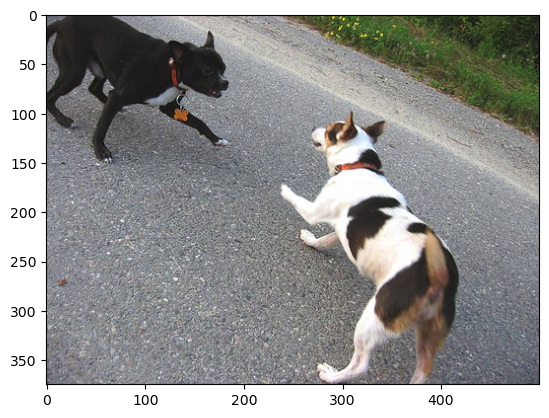

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .


In [32]:
image_idx = 1

train_path = "./image_train"
image_train = Path.cwd() / train_path
list_train = os.listdir(image_train)
#print(list_train[image_idx])

image_path = "./flickr8k/Images/"+list_train[image_idx]
print(image_path)
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

extract_rule = (dataset['image']==list_train[image_idx])
thisimage_with_captions = dataset[extract_rule]
for i in thisimage_with_captions['caption']:
    print(i)

## 2. Construct data loader

Some helper functions from link: https://gist.github.com/MdTeach/2571ca46af9d9661de52d2adb879f801

In [102]:
import spacy

spacy_en = spacy.load("en_core_web_sm")

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

print(tokenize_en("Hello, my name is tom."))


['Hello', ',', 'my', 'name', 'is', 'tom', '.']


In [103]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image

class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
        
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        
        #staring index 4
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
    
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset
    
    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset 
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)  
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader

Helper function to plot tensor image

In [104]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [105]:
data_location =  "./flickr8k"
BATCH_SIZE = 128
NUM_WORKER = 0

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    caption_file = data_location+"/captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)

In [106]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [114]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]
        
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [119]:
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [120]:
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1 loss: 7.99398
tensor([[[[ 1.7523,  1.7865,  1.7694,  ...,  0.6221,  0.6906,  0.7248],
          [ 1.7865,  1.7694,  1.8037,  ...,  1.2728,  1.2214,  1.2043],
          [ 1.7865,  1.7352,  1.8037,  ...,  0.6734,  0.6392,  0.5878],
          ...,
          [ 2.2318,  2.2318,  2.2318,  ...,  0.1939,  0.3994,  0.4166],
          [ 2.2147,  2.2318,  2.2318,  ...,  0.1597,  0.1426,  0.0227],
          [ 2.2147,  2.2318,  2.2318,  ...,  0.2282,  0.4851,  0.3138]],

         [[ 1.8333,  1.8333,  1.8158,  ...,  0.3277,  0.3277,  0.3978],
          [ 1.8508,  1.8158,  1.8508,  ...,  1.1681,  1.1506,  1.1506],
          [ 1.8333,  1.7983,  1.8508,  ...,  0.4153,  0.3627,  0.3277],
          ...,
          [ 2.4111,  2.4111,  2.4111,  ..., -0.6176, -0.4251, -0.3550],
          [ 2.3936,  2.4111,  2.4111,  ..., -0.5651, -0.5651, -0.5476],
          [ 2.3936,  2.4111,  2.4111,  ..., -0.3725, -0.1450, -0.1800]],

         [[ 1.6814,  1.7163,  1.6988,  ...,  0.2522,  0.3045,  0.3916],
       

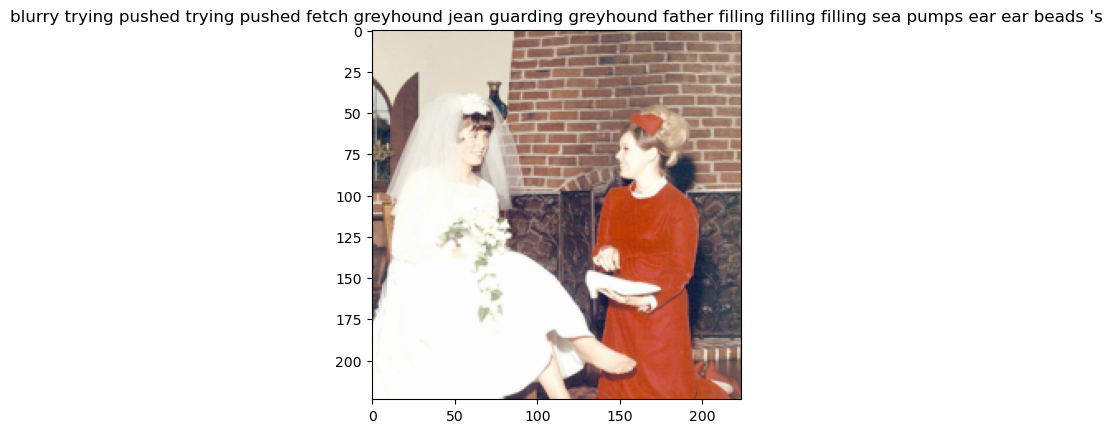

KeyboardInterrupt: 

In [121]:
num_epochs = 1
print_every = 1

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                print(img)
                print(type(img))
                print(img.shape)
                print(img[0:1].shape)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

Save the model

In [27]:
torch.save(model.state_dict(), "CNN_RNN_model")

Use the save model to do image captioning

there is a saved jpg picture called surf in the root

In [125]:
img_path = "./surf.jpg"
print(img_path)
img=Image.open(img_path)
img = img.convert("RGB")
print(type(img))


./surf.jpg
<class 'PIL.Image.Image'>


In [134]:
transform = T.Compose([T.Resize((224,224)), T.ToTensor(),T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
tensor_img = transform(img)
print(tensor_img.shape)
# tensor_img = np.expand_dims(tensor_img,0)
tensor_img = torch.unsqueeze(tensor_img, dim=0)
print(tensor_img.shape)
#show_image(tensor_img, title=None)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [135]:
# load the model
saved_model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
saved_model.load_state_dict(torch.load("CNN_RNN_model"))
# saved_model.modules

<All keys matched successfully>

<SOS> a man in a red shirt is standing on a bench with a dog in the background . <EOS>


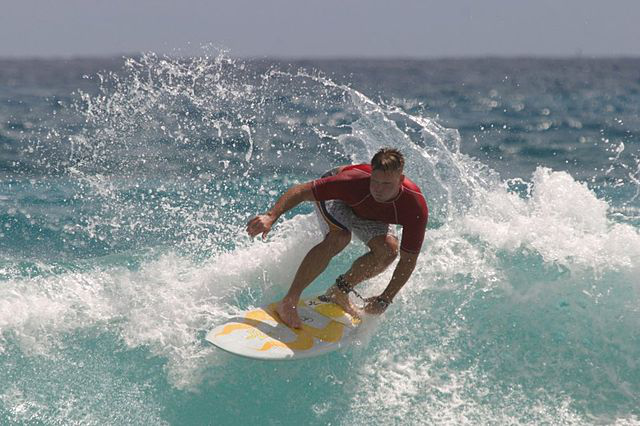

In [146]:
features = saved_model.encoder(tensor_img.cuda())
caps = saved_model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
caption = ' '.join(caps)
print(caption)
img